In [1]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
import os
import sys
import statannot
import warnings
from scipy.stats import ttest_ind, ttest_rel, ttest_1samp 
warnings.filterwarnings('ignore')

# Define common functions

In [2]:
def load_data(ratemapDir, animal_id, normalizeNeuron=True, normalizeVel=True, normalizeLickrate=True, scaleNeuron=False, scaleVel=True, scaleLickrate=True, resample=False, min_timebin=-1.8, max_timebin=3.2):
    '''
    load ratemap, lickrate and velocity files generated by generateMatForJupyter.m. 
    normalizeNeuron: for each neuron and each trial, divide firing rate by the max firing rate.
    scaleNeuron: for each trial, subtract the firing rate by the average firing rate of the first 3 time bins of all neurons. Can cause negative firing rate, making bar plot confusing.
    min_timebin = min_time_bin (in MATLAB) -> binEdges value / 30000 -> + 0.2
    max_timebin = max_time_bin (in MATLAB) -> binEdges value / 30000 -> + 0.4
    '''

    # filtering criteria
    min_freq = 5

    # selected_neurons = [0, 6, 7, 8]

    ## ratemap
    ### load data, select trials and neurons
    allfiles = os.listdir(ratemapDir)
    datesincl = [211022, 230720, 230721, 230805, 230806, 230808] # velocity of 230719 data is messy, excluded
    if type(animal_id) == str:
        animal_id = [animal_id]
    elif type(animal_id) == list:
        animal_id = animal_id
    else:
        print("animal_id must be str or list, for 1 or multiple animals respectively")
    allfiles = list(set([item for item in allfiles if any(str(x) in item for x in datesincl)]) & set([item for item in allfiles if any(str(x) in item for x in animal_id)]))

    velocity_ctrl_files = list(set(allfiles) & set([item for item in allfiles if all(str(x) in item for x in ["velocity", "ctrl"])]))
    lickrate_ctrl_files = list(set(allfiles) & set([item for item in allfiles if all(str(x) in item for x in ["lickrate", "ctrl"])]))
    ratemap_ctrl_files = list(set(allfiles) & set([item for item in allfiles if all(str(x) in item for x in ["ratemap", "ctrl"])]))
    velocity_freeze_files = list(set(allfiles) & set([item for item in allfiles if all(str(x) in item for x in ["velocity", "freeze"])]))
    lickrate_freeze_files = list(set(allfiles) & set([item for item in allfiles if all(str(x) in item for x in ["lickrate", "freeze"])]))
    ratemap_freeze_files = list(set(allfiles) & set([item for item in allfiles if all(str(x) in item for x in ["ratemap", "freeze"])]))
    ratemap_ctrl_all_trialvar = []
    ratemap_freeze_all_trialvar = []
    ratemap_ctrl_all_neuronvar = []
    ratemap_freeze_all_neuronvar = []
    ratemap_diff_all_neuronvar = []
    trials_ctrl = []
    trials_freeze = []
    ctrl_subsetind_ls = []
    freeze_subsetind_ls = []
    for fidx in range(len(ratemap_freeze_files)):
        prefix = ratemap_freeze_files[fidx][0:-33]
        ratemap_ctrl = loadmat(ratemapDir + prefix + "ratemap_bin200ms_6s_RZ_ctrl.mat")["ratemap_ctrl"] 
        if len(ratemap_ctrl.shape) < 3:
            ratemap_ctrl = ratemap_ctrl[:, :, np.newaxis]
        ratemap_ctrl = np.moveaxis(ratemap_ctrl, 2, 0)
        
        ratemap_freeze = loadmat(ratemapDir + prefix + "ratemap_bin200ms_6s_RZ_freeze.mat")["ratemap_freeze"]
        if len(ratemap_freeze.shape) < 3:
            ratemap_freeze = ratemap_freeze[:, :, np.newaxis]
        ratemap_freeze = np.moveaxis(ratemap_freeze, 2, 0)
        ### select neuron - firing more than half of the time
        ################################################
        neuron_ctrl = np.where(np.count_nonzero(ratemap_ctrl, axis=(1,2))>=1/2*ratemap_ctrl.shape[1]*ratemap_ctrl.shape[2])[0]
        neuron_freeze = np.where(np.count_nonzero(ratemap_freeze, axis=(1,2))>=1/2*ratemap_freeze.shape[1]*ratemap_freeze.shape[2])[0]
        neuron_selected = np.union1d(neuron_ctrl, neuron_freeze)
        ratemap_ctrl = ratemap_ctrl[neuron_selected, :, :]
        ratemap_freeze = ratemap_freeze[neuron_selected, :,:] # select neurons without too many 0 firing rates
        ################################################
        ### select trial
        trial_ctrl = np.arange(np.shape(ratemap_ctrl)[1])
        ratemap_ctrl = ratemap_ctrl[:, trial_ctrl, :]
        
        trial_freeze = np.arange(np.shape(ratemap_freeze)[1])
        ratemap_freeze = ratemap_freeze[:, trial_freeze, :]
        
        trials_ctrl.append(trial_ctrl)
        trials_freeze.append(trial_freeze)

        ### resample to match the trial number between ctrl and freeze trials
        ctrl_trial_num = ratemap_ctrl.shape[1]
        freeze_trial_num = ratemap_freeze.shape[1]
        if resample == True:
            np.random.seed(100)
            subsetind = np.random.choice(np.arange(np.max([ctrl_trial_num, freeze_trial_num])), np.min([ctrl_trial_num, freeze_trial_num]), replace = False)
            if ctrl_trial_num == np.max([ctrl_trial_num, freeze_trial_num]):
                ctrl_subsetind = subsetind
                freeze_subsetind = np.arange(freeze_trial_num)
            else:
                ctrl_subsetind = np.arange(ctrl_trial_num)
                freeze_subsetind = subsetind
            ratemap_ctrl = ratemap_ctrl[:, ctrl_subsetind, :]
            ratemap_freeze = ratemap_freeze[:, freeze_subsetind, :]  
            ctrl_subsetind_ls.append(ctrl_subsetind)
            freeze_subsetind_ls.append(freeze_subsetind)
        ### scaling within trials 
        if scaleNeuron == True: 
            for n in range(ratemap_ctrl.shape[0]): # each neuron in ctrl or freeze session
                for t in range(ratemap_ctrl.shape[1]): 
                    ratemap_ctrl[n, t, :] = ratemap_ctrl[n, t, :] - np.mean(ratemap_ctrl[n, t][0:3])
                for t in range(ratemap_freeze.shape[1]):
                    ratemap_freeze[n, t, :] = ratemap_freeze[n, t, :] - np.mean(ratemap_freeze[n, t][0:3])   
        ### normalization across neurons
        if normalizeNeuron == True:
            for n in range(ratemap_ctrl.shape[0]):
#                 for t in range(ratemap_ctrl.shape[1]):
                    if np.max(ratemap_ctrl[n, :, :]) != 0:
                        ratemap_ctrl[n, :, :] = ratemap_ctrl[n, :, :]/np.max(ratemap_ctrl[n, :, :]) # alternative: take mean
            for n in range(ratemap_freeze.shape[0]):
#                 for t in range(ratemap_freeze.shape[1]):
                    if np.max(ratemap_freeze[n, :, :]) != 0:
                        ratemap_freeze[n, :, :] = ratemap_freeze[n, :, :]/np.max(ratemap_freeze[n, :, :])
             
        ### select neuron - significantly decrease anytime in -0.5~3 sec
        ################################################
        neuron_selected1 = []
        timerange = np.round(np.arange(min_timebin, max_timebin,0.2),2)
        for n in range(ratemap_ctrl.shape[0]):
            t_sig = 0
            t_total = 0
            for t in range(8, ratemap_ctrl.shape[2]-10):
                statistic_ctrl, p_value_ctrl = ttest_rel(ratemap_ctrl[n, :, t:t+3].reshape(-1), ratemap_ctrl[n, :, 0:3].reshape(-1), alternative='less')
                statistic_freeze, p_value_freeze = ttest_rel(ratemap_freeze[n, :, t:t+3].reshape(-1), ratemap_freeze[n, :, 0:3].reshape(-1), alternative='less')
                t_total += 1
                if (p_value_ctrl <= 0.05) | (p_value_freeze <= 0.05):
                    t_sig += 1
            if t_sig >= t_total/2:
                neuron_selected1.append(n)
        ratemap_ctrl = ratemap_ctrl[np.unique(neuron_selected1), :, :]
        ratemap_freeze = ratemap_freeze[np.unique(neuron_selected1), :,:] # select neurons without too many 0 firing rates
        ################################################
        
        ratemap_ctrl_trialvar = ratemap_ctrl.reshape(ratemap_ctrl.shape[0] * ratemap_ctrl.shape[1], ratemap_ctrl.shape[2])
        ratemap_freeze_trialvar = ratemap_freeze.reshape(ratemap_freeze.shape[0] * ratemap_freeze.shape[1], ratemap_freeze.shape[2])
        if len(ratemap_ctrl_all_trialvar) == 0:
            ratemap_ctrl_all_trialvar = ratemap_ctrl_trialvar
            ratemap_freeze_all_trialvar = ratemap_freeze_trialvar
        else:
            ratemap_ctrl_all_trialvar = np.concatenate([ratemap_ctrl_all_trialvar, ratemap_ctrl_trialvar], axis = 0) # vertical concat, across trials
            ratemap_freeze_all_trialvar = np.concatenate([ratemap_freeze_all_trialvar, ratemap_freeze_trialvar], axis = 0) 

        ratemap_ctrl_neuronvar = np.mean(ratemap_ctrl, axis=1)# average across trials
        ratemap_freeze_neuronvar = np.mean(ratemap_freeze, axis=1) # average across trials
        if len(ratemap_ctrl_all_neuronvar) == 0:
            ratemap_ctrl_all_neuronvar = ratemap_ctrl_neuronvar
            ratemap_freeze_all_neuronvar = ratemap_freeze_neuronvar
        else:
            ratemap_ctrl_all_neuronvar = np.concatenate([ratemap_ctrl_all_neuronvar, ratemap_ctrl_neuronvar], axis = 0) # vertical concat, across neurons
            ratemap_freeze_all_neuronvar = np.concatenate([ratemap_freeze_all_neuronvar, ratemap_freeze_neuronvar], axis = 0) 

        ratemap_diff_neuronvar = ratemap_freeze_neuronvar - ratemap_ctrl_neuronvar
        if len(ratemap_diff_all_neuronvar) == 0:
            ratemap_diff_all_neuronvar = ratemap_diff_neuronvar
        else:
            ratemap_diff_all_neuronvar = np.concatenate([ratemap_diff_all_neuronvar, ratemap_diff_neuronvar])
            
    ratemap_df_ctrl_trialvar = pd.DataFrame(ratemap_ctrl_all_trialvar.T)
    ratemap_df_ctrl_trialvar["Time to RZ (s)"] = np.round(np.arange(min_timebin, max_timebin,0.2),2)
    ratemap_df_ctrl_trialvar["Condition"] = "Ctrl"
    ratemap_df_ctrl_trialvar = pd.melt(ratemap_df_ctrl_trialvar, id_vars=["Time to RZ (s)", "Condition"])
    ratemap_df_freeze_trialvar = pd.DataFrame(ratemap_freeze_all_trialvar.T)
    ratemap_df_freeze_trialvar["Time to RZ (s)"] = np.round(np.arange(min_timebin, max_timebin,0.2),2)
    ratemap_df_freeze_trialvar["Condition"] = "Freeze at RZ"
    ratemap_df_freeze_trialvar = pd.melt(ratemap_df_freeze_trialvar, id_vars=["Time to RZ (s)", "Condition"])
    ratemap_df_trialvar = ratemap_df_ctrl_trialvar._append(ratemap_df_freeze_trialvar)

    ratemap_df_ctrl_neuronvar = pd.DataFrame(ratemap_ctrl_all_neuronvar.T)
    ratemap_df_ctrl_neuronvar["Time to RZ (s)"] = np.round(np.arange(min_timebin, max_timebin,0.2),2)
    ratemap_df_ctrl_neuronvar["Condition"] = "Ctrl"
    ratemap_df_ctrl_neuronvar = pd.melt(ratemap_df_ctrl_neuronvar, id_vars=["Time to RZ (s)", "Condition"])
    ratemap_df_freeze_neuronvar = pd.DataFrame(ratemap_freeze_all_neuronvar.T)
    ratemap_df_freeze_neuronvar["Time to RZ (s)"] = np.round(np.arange(min_timebin, max_timebin,0.2),2)
    ratemap_df_freeze_neuronvar["Condition"] = "Freeze at RZ"
    ratemap_df_freeze_neuronvar = pd.melt(ratemap_df_freeze_neuronvar, id_vars=["Time to RZ (s)", "Condition"])
    ratemap_df_neuronvar = ratemap_df_ctrl_neuronvar._append(ratemap_df_freeze_neuronvar)
    
    ratemap_df_diff_neuronvar = pd.DataFrame(ratemap_diff_all_neuronvar.T)
    ratemap_df_diff_neuronvar["Time to RZ (s)"] = np.round(np.arange(min_timebin, max_timebin,0.2),2)
    ratemap_df_diff_neuronvar["Condition"] = "Freeze - Ctrl"
    ratemap_df_diff_neuronvar = pd.melt(ratemap_df_diff_neuronvar, id_vars=["Time to RZ (s)", "Condition"])
    
    ## lickrate
    lickrate_ctrl_all = []
    lickrate_freeze_all = []
    for fidx in range(len(ratemap_freeze_files)):
        prefix = ratemap_freeze_files[fidx][0:-33]
        lickrate_ctrl = loadmat(ratemapDir + prefix + "lickrate_bin200ms_6s_RZ_ctrl.mat")["lickrate_ctrl"]
        lickrate_freeze = loadmat(ratemapDir + prefix + "lickrate_bin200ms_6s_RZ_freeze.mat")["lickrate_freeze"]
        if resample == 1:
            lickrate_ctrl = lickrate_ctrl[ctrl_subsetind_ls[fidx]]
            lickrate_freeze = lickrate_freeze[freeze_subsetind_ls[fidx]] 
        if len(lickrate_ctrl_all) == 0:
            lickrate_ctrl_all = lickrate_ctrl
            lickrate_freeze_all = lickrate_freeze
        else:
            lickrate_ctrl_all = np.concatenate([lickrate_ctrl_all, lickrate_ctrl], axis = 0) # axis=0: vertical concat
            lickrate_freeze_all = np.concatenate([lickrate_freeze_all, lickrate_freeze], axis = 0) 
    ### normalization
    if normalizeLickrate == True:
        for t in range(lickrate_ctrl_all.shape[0]):
            lickrate_ctrl_all[t, :] = lickrate_ctrl_all[t, :]/np.max(lickrate_ctrl_all[t, :]) # alternative: take mean
        for t in range(lickrate_freeze_all.shape[0]):
            lickrate_freeze_all[t, :] = lickrate_freeze_all[t, :]/np.max(lickrate_freeze_all[t, :]) # alternative: take mean
    ### scaling within trials
    if scaleLickrate == True: 
        for t in range(lickrate_ctrl_all.shape[0]): 
            lickrate_ctrl_all[t] = lickrate_ctrl_all[t] - np.mean(lickrate_ctrl_all[t][0:3])
        for t in range(lickrate_freeze_all.shape[0]):
            lickrate_freeze_all[t] = lickrate_freeze_all[t] - np.mean(lickrate_freeze_all[t][0:3])
    lickrate_df_ctrl = pd.DataFrame(lickrate_ctrl_all.T)
    lickrate_df_ctrl["Time to RZ (s)"] = np.round(np.arange(min_timebin, max_timebin,0.2),2)
    lickrate_df_ctrl["Condition"] = "Ctrl"
    lickrate_df_ctrl = pd.melt(lickrate_df_ctrl, id_vars=["Time to RZ (s)", "Condition"])

    lickrate_df_freeze = pd.DataFrame(lickrate_freeze_all.T)
    lickrate_df_freeze["Time to RZ (s)"] = np.round(np.arange(min_timebin, max_timebin,0.2),2)
    lickrate_df_freeze["Condition"] = "Freeze at RZ"
    lickrate_df_freeze = pd.melt(lickrate_df_freeze, id_vars=["Time to RZ (s)", "Condition"])

    lickrate_df = lickrate_df_ctrl._append(lickrate_df_freeze)
    
    ## velocity
    velocity_ctrl_all = []
    velocity_freeze_all = []
    for fidx in range(len(ratemap_freeze_files)):
        prefix = ratemap_freeze_files[fidx][0:-33]
        velocity_ctrl = loadmat(ratemapDir + prefix + "velocity_bin200ms_6s_RZ_ctrl.mat")["velocity_ctrl"]
        velocity_freeze = loadmat(ratemapDir + prefix + "velocity_bin200ms_6s_RZ_freeze.mat")["velocity_freeze"]
        if resample == 1:
            velocity_ctrl = velocity_ctrl[ctrl_subsetind_ls[fidx]]
            velocity_freeze = velocity_freeze[freeze_subsetind_ls[fidx]] 
        if len(velocity_ctrl_all) == 0:
            velocity_ctrl_all = velocity_ctrl
            velocity_freeze_all = velocity_freeze
        else:
            velocity_ctrl_all = np.concatenate([velocity_ctrl_all, velocity_ctrl], axis = 0) # axis=0: vertical concat
            velocity_freeze_all = np.concatenate([velocity_freeze_all, velocity_freeze], axis = 0) 
    ### normalization
    if normalizeVel == True:
        for t in range(velocity_ctrl_all.shape[0]):
            velocity_ctrl_all[t, :] = velocity_ctrl_all[t, :]/np.max(velocity_ctrl_all[t, :]) # alternative: take mean
        for t in range(velocity_freeze_all.shape[0]):
            velocity_freeze_all[t, :] = velocity_freeze_all[t, :]/np.max(velocity_freeze_all[t, :]) # alternative: take mean
    ## scaling within trials
    if scaleVel == True: 
        for t in range(velocity_ctrl_all.shape[0]): 
            velocity_ctrl_all[t] = velocity_ctrl_all[t] - np.mean(velocity_ctrl_all[t][0:3])
        for t in range(velocity_freeze_all.shape[0]):
            velocity_freeze_all[t] = velocity_freeze_all[t] - np.mean(velocity_freeze_all[t][0:3])
    velocity_df_ctrl = pd.DataFrame(velocity_ctrl_all.T)
    velocity_df_ctrl["Time to RZ (s)"] = np.round(np.arange(min_timebin, max_timebin,0.2),2)
    velocity_df_ctrl["Condition"] = "Ctrl"
    velocity_df_ctrl = pd.melt(velocity_df_ctrl, id_vars=["Time to RZ (s)", "Condition"])

    velocity_df_freeze = pd.DataFrame(velocity_freeze_all.T)
    velocity_df_freeze["Time to RZ (s)"] = np.round(np.arange(min_timebin, max_timebin,0.2),2)
    velocity_df_freeze["Condition"] = "Freeze at RZ"
    velocity_df_freeze = pd.melt(velocity_df_freeze, id_vars=["Time to RZ (s)", "Condition"])

    velocity_df = velocity_df_ctrl._append(velocity_df_freeze)

    ctrl_trial_num = velocity_ctrl_all.shape[0]
    freeze_trial_num = velocity_freeze_all.shape[0]
    neuron_num = ratemap_freeze_all_neuronvar.shape[0]
    return (ratemap_df_trialvar, ratemap_df_neuronvar, ratemap_df_diff_neuronvar, lickrate_df, velocity_df, ctrl_trial_num, freeze_trial_num, neuron_num)

In [3]:
def plot_time_course(animal_id, ratemap_df, lickrate_df, velocity_df, ctrl_trial_num, freeze_trial_num, saveDir):
    palette = {
        'Ctrl': 'tab:grey',
        'Freeze at RZ': 'tab:cyan',
    }
#     sns.set(style="whitegrid")
    ratemap_df = ratemap_df.reset_index(drop=True)
    lickrate_df = lickrate_df.reset_index(drop=True)
    velocity_df = velocity_df.reset_index(drop=True)
    
    figs, axs = plt.subplots(nrows=3, figsize=(8, 9), dpi=300)
    g1=sns.lineplot(data=lickrate_df, x="Time to RZ (s)", y="value", hue="Condition", palette=palette, err_style="band",ax=axs[0])
    g2=sns.lineplot(data=velocity_df, x="Time to RZ (s)", y="value", hue="Condition", palette=palette, err_style="band",ax=axs[1])
    g3=sns.lineplot(data=ratemap_df, x="Time to RZ (s)", y="value", hue="Condition", palette=palette, err_style="band",ax=axs[2])

    g1.set(xlabel=None) 
    g2.set(xlabel=None) 

    axs[0].set_ylabel("Lick Rate")
    axs[1].set_ylabel("Velocity")
    axs[2].set_ylabel("Firing Rate")
    axs[0].get_legend().remove()
    axs[2].get_legend().remove()
    legend = g2.get_legend()

    # Remove two of the four lines (associated with the shades)
    for line in legend.get_lines()[2:]:
        line.set_visible(False)
    for text in legend.get_texts()[2:]:
        text.set_text('')
    legend.get_texts()[0].set_text("Ctrl (# trials="+str(ctrl_trial_num)+")")
    legend.get_texts()[1].set_text("Freeze At RZ (# trials="+str(freeze_trial_num)+")")
    axs[1].legend_.set_bbox_to_anchor((1.4, 1))
    g1.set_title(animal_id, fontsize = 15)
    axs[0].spines["right"].set_visible(False)
    axs[0].spines["top"].set_visible(False)
    axs[1].spines["right"].set_visible(False)
    axs[1].spines["top"].set_visible(False)
    axs[2].spines["right"].set_visible(False)
    axs[2].spines["top"].set_visible(False)
    plt.savefig(os.path.join(saveDir, 'ExtendedDataFigure03_C_' + animal_id + "_freeze_timecourse.svg"))

In [4]:
def plot_bars(animal_id, lickrate_df, velocity_df, ratemap_df, min_time, max_time, saveDir):
#     velocity_selected = velocity_df[(velocity_df["Time to RZ (s)"] >=min_time) & (velocity_df["Time to RZ (s)"] <=max_time)].groupby(["Time to RZ (s)", "Condition"]).mean().reset_index() 
#     ratemap_selected = ratemap_df[(ratemap_df["Time to RZ (s)"] >=min_time) & (ratemap_df["Time to RZ (s)"] <=max_time)].groupby(["Time to RZ (s)", "Condition"]).mean().reset_index()
    lickrate_selected = lickrate_df[(lickrate_df["Time to RZ (s)"] >=min_time) & (lickrate_df["Time to RZ (s)"] <=max_time)].groupby(["variable", "Condition"]).mean().reset_index() 
    velocity_selected = velocity_df[(velocity_df["Time to RZ (s)"] >=min_time) & (velocity_df["Time to RZ (s)"] <=max_time)].groupby(["variable", "Condition"]).mean().reset_index() 
    ratemap_selected = ratemap_df[(ratemap_df["Time to RZ (s)"] >=min_time) & (ratemap_df["Time to RZ (s)"] <=max_time)].groupby(["variable", "Condition"]).mean().reset_index()
    fig, axs = plt.subplots(ncols=3, figsize=(15,6), dpi=300)

    x = "Condition"
    y = "value"
    order = ['Ctrl', 'Freeze at RZ']
    palette = {
            'Ctrl': 'tab:grey',
            'Freeze at RZ': 'tab:cyan',
        }
    g0 = sns.barplot(data=lickrate_selected, x=x, y=y, order=order, width=0.8, palette=palette, ax=axs[0], alpha = 0.5)
    sns.stripplot(data=lickrate_selected, x=x, y=y, order=order, palette=palette, ax=axs[0], s = 8)
    axs[0].set(ylabel = "Lick Rate")
    add_stat_annotation(axs[0], data=lickrate_selected, x=x, y=y, order=order,
                        box_pairs=[('Ctrl', 'Freeze at RZ')],
                        test='t-test_paired', text_format='star', loc='outside', verbose=2)
    g1 = sns.barplot(data=velocity_selected, x=x, y=y, order=order, width=0.8, palette=palette, ax=axs[1], alpha = 0.5)
    sns.stripplot(data=velocity_selected, x=x, y=y, order=order, palette=palette, ax=axs[1], s = 8)
    axs[1].set(ylabel = "Velocity")
    add_stat_annotation(axs[1], data=velocity_selected, x=x, y=y, order=order,
                        box_pairs=[('Ctrl', 'Freeze at RZ')],
                        test='t-test_paired', text_format='star', loc='outside', verbose=2)
    g2 = sns.barplot(data=ratemap_selected, x=x, y=y, order=order, width=0.8, palette=palette, ax=axs[2], alpha = 0.5)
    sns.stripplot(data=ratemap_selected, x=x, y=y, order=order, palette=palette, ax=axs[2], s = 8, jitter=False)
    axs[2].set(ylabel = "Firing Rate")
    group1 = ratemap_selected[(ratemap_selected['Condition'] == 'Freeze at RZ')]['value']
    group2 = ratemap_selected[(ratemap_selected['Condition'] == 'Ctrl')]['value']
    statistic, p_value = ttest_rel(group1, group2, alternative='less')
    add_stat_annotation(axs[2], perform_stat_test = False,
                        data=ratemap_selected, x=x, y=y, order=order,
                        box_pairs=[('Ctrl', 'Freeze at RZ')],
#                         test='t-test_paired', text_format='star', loc='outside', verbose=0,
                        test=None, text_format='star', loc='outside', verbose=2,
                        pvalues = [p_value])

    axs[0].spines["right"].set_visible(False)
    axs[0].spines["top"].set_visible(False)
    axs[1].spines["right"].set_visible(False)
    axs[1].spines["top"].set_visible(False)
    axs[2].spines["right"].set_visible(False)
    axs[2].spines["top"].set_visible(False)
    
    neurons = np.unique(ratemap_selected["variable"])
    for n in neurons:
        ratemap_selected_perneuron = ratemap_selected[ratemap_selected["variable"] == n][["Condition", "value"]]
        len_idx = len(ratemap_selected_perneuron.index)
        for idx in range(int(len_idx/2)):
            idx = int(idx)
            idx_f = int(idx + len_idx/2)
            # this is a stupid way to plot but worked
            df = pd.DataFrame({'Ctrl': np.array(ratemap_selected_perneuron.iloc[idx]["value"]), 'Freeze at RZ': np.array(ratemap_selected_perneuron.iloc[idx_f]["value"])}, index = [0])
            axs[2].plot(df.loc[df.index[0], ['Ctrl', 'Freeze at RZ']], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)
    plt.savefig(os.path.join(saveDir, 'ExtendedDataFigure03_C_' + animal_id + "_freeze_bars.svg"))
    plt.savefig(os.path.join(saveDir, 'ExtendedDataFigure03_C_' + animal_id + "_freeze_bars.pdf"))
    return statistic, p_value

# N46

In [5]:
ratemapDir = "Y:/labs/singer/Xiao/Code/projects/nuri_manuscript_figs/ManuscriptCode/InhibitoryGating2023/Demo_Data/vr_manipulation_data/"
figDir = "Y:/labs/singer/Xiao/Code/projects/nuri_manuscript_figs/ManuscriptCode/InhibitoryGating2023/Demo_Figures/"

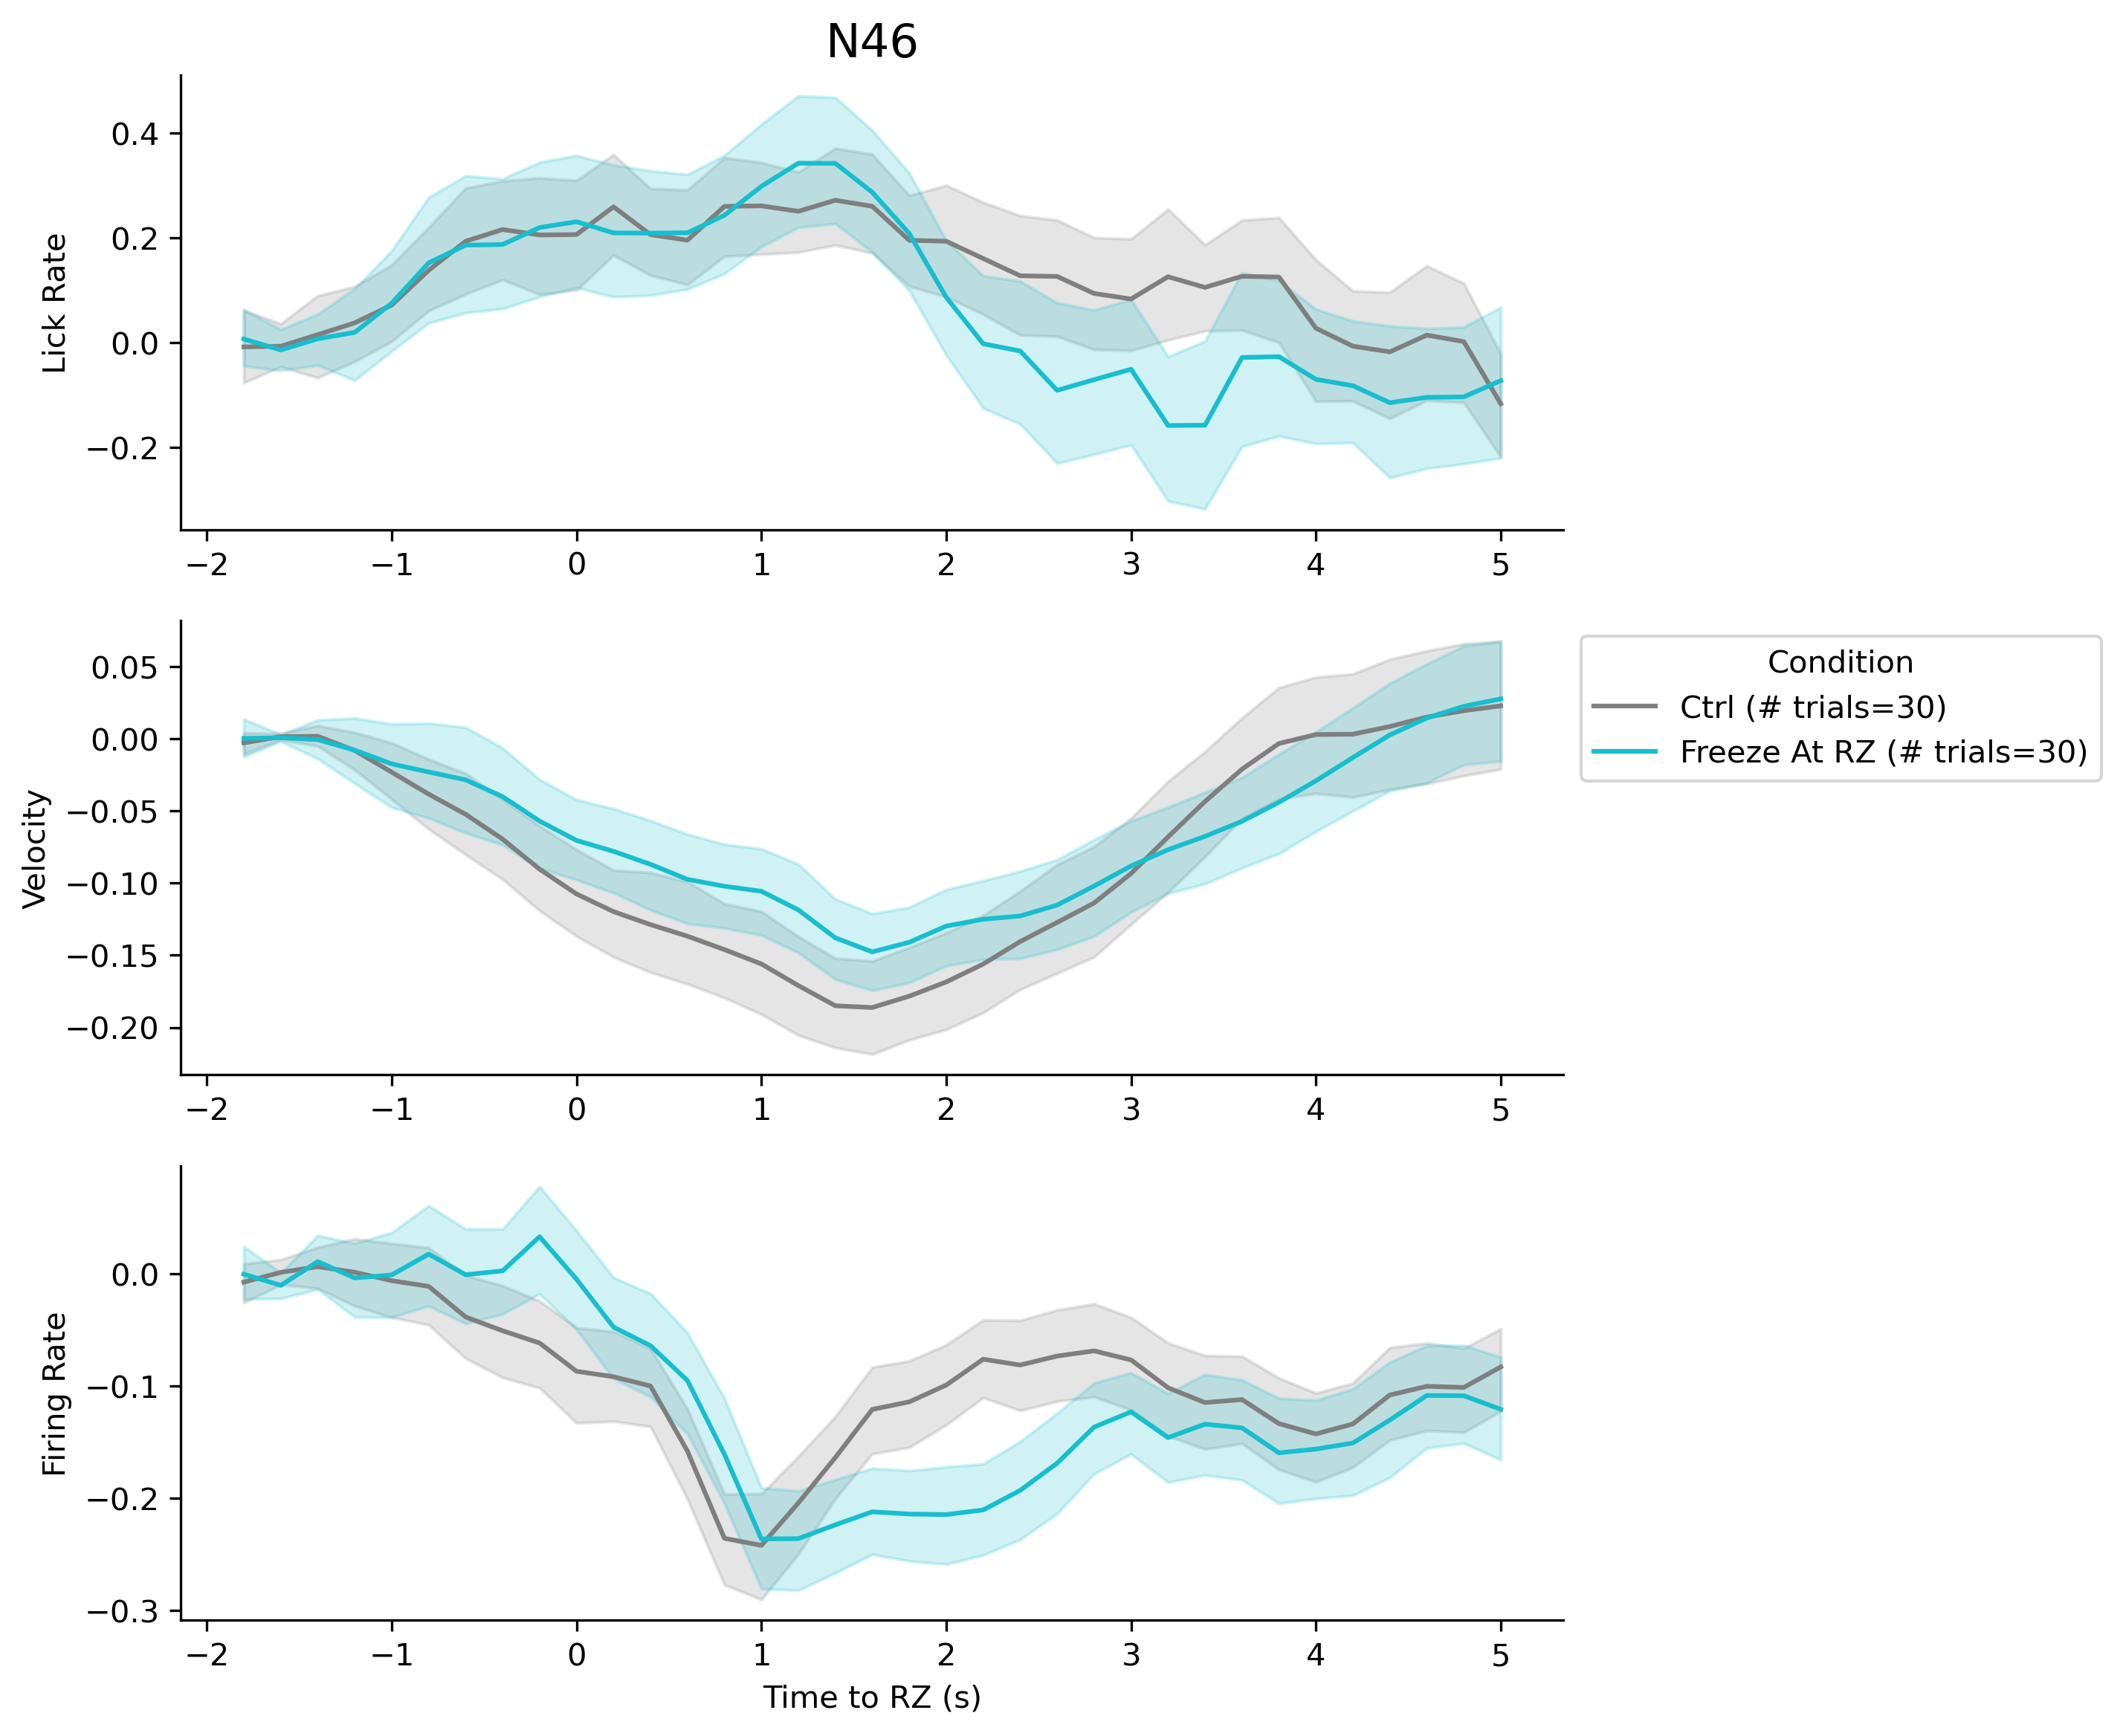

In [6]:
N46_ratemap_df_trialvar, N46_ratemap_df_neuronvar, N46_ratemap_df_diff_neuronvar, N46_lickrate_df, N46_velocity_df, N46_ctrl_trial_num, N46_freeze_trial_num, N46_neuron_num = load_data(ratemapDir, "N46", normalizeNeuron=True, normalizeVel=True, normalizeLickrate=True, scaleNeuron=True, scaleVel=True, scaleLickrate=True, resample = True, min_timebin = -1.8, max_timebin = 5.2)
plot_time_course("N46", N46_ratemap_df_trialvar, N46_lickrate_df, N46_velocity_df, N46_ctrl_trial_num, N46_freeze_trial_num, saveDir=figDir)

# N47

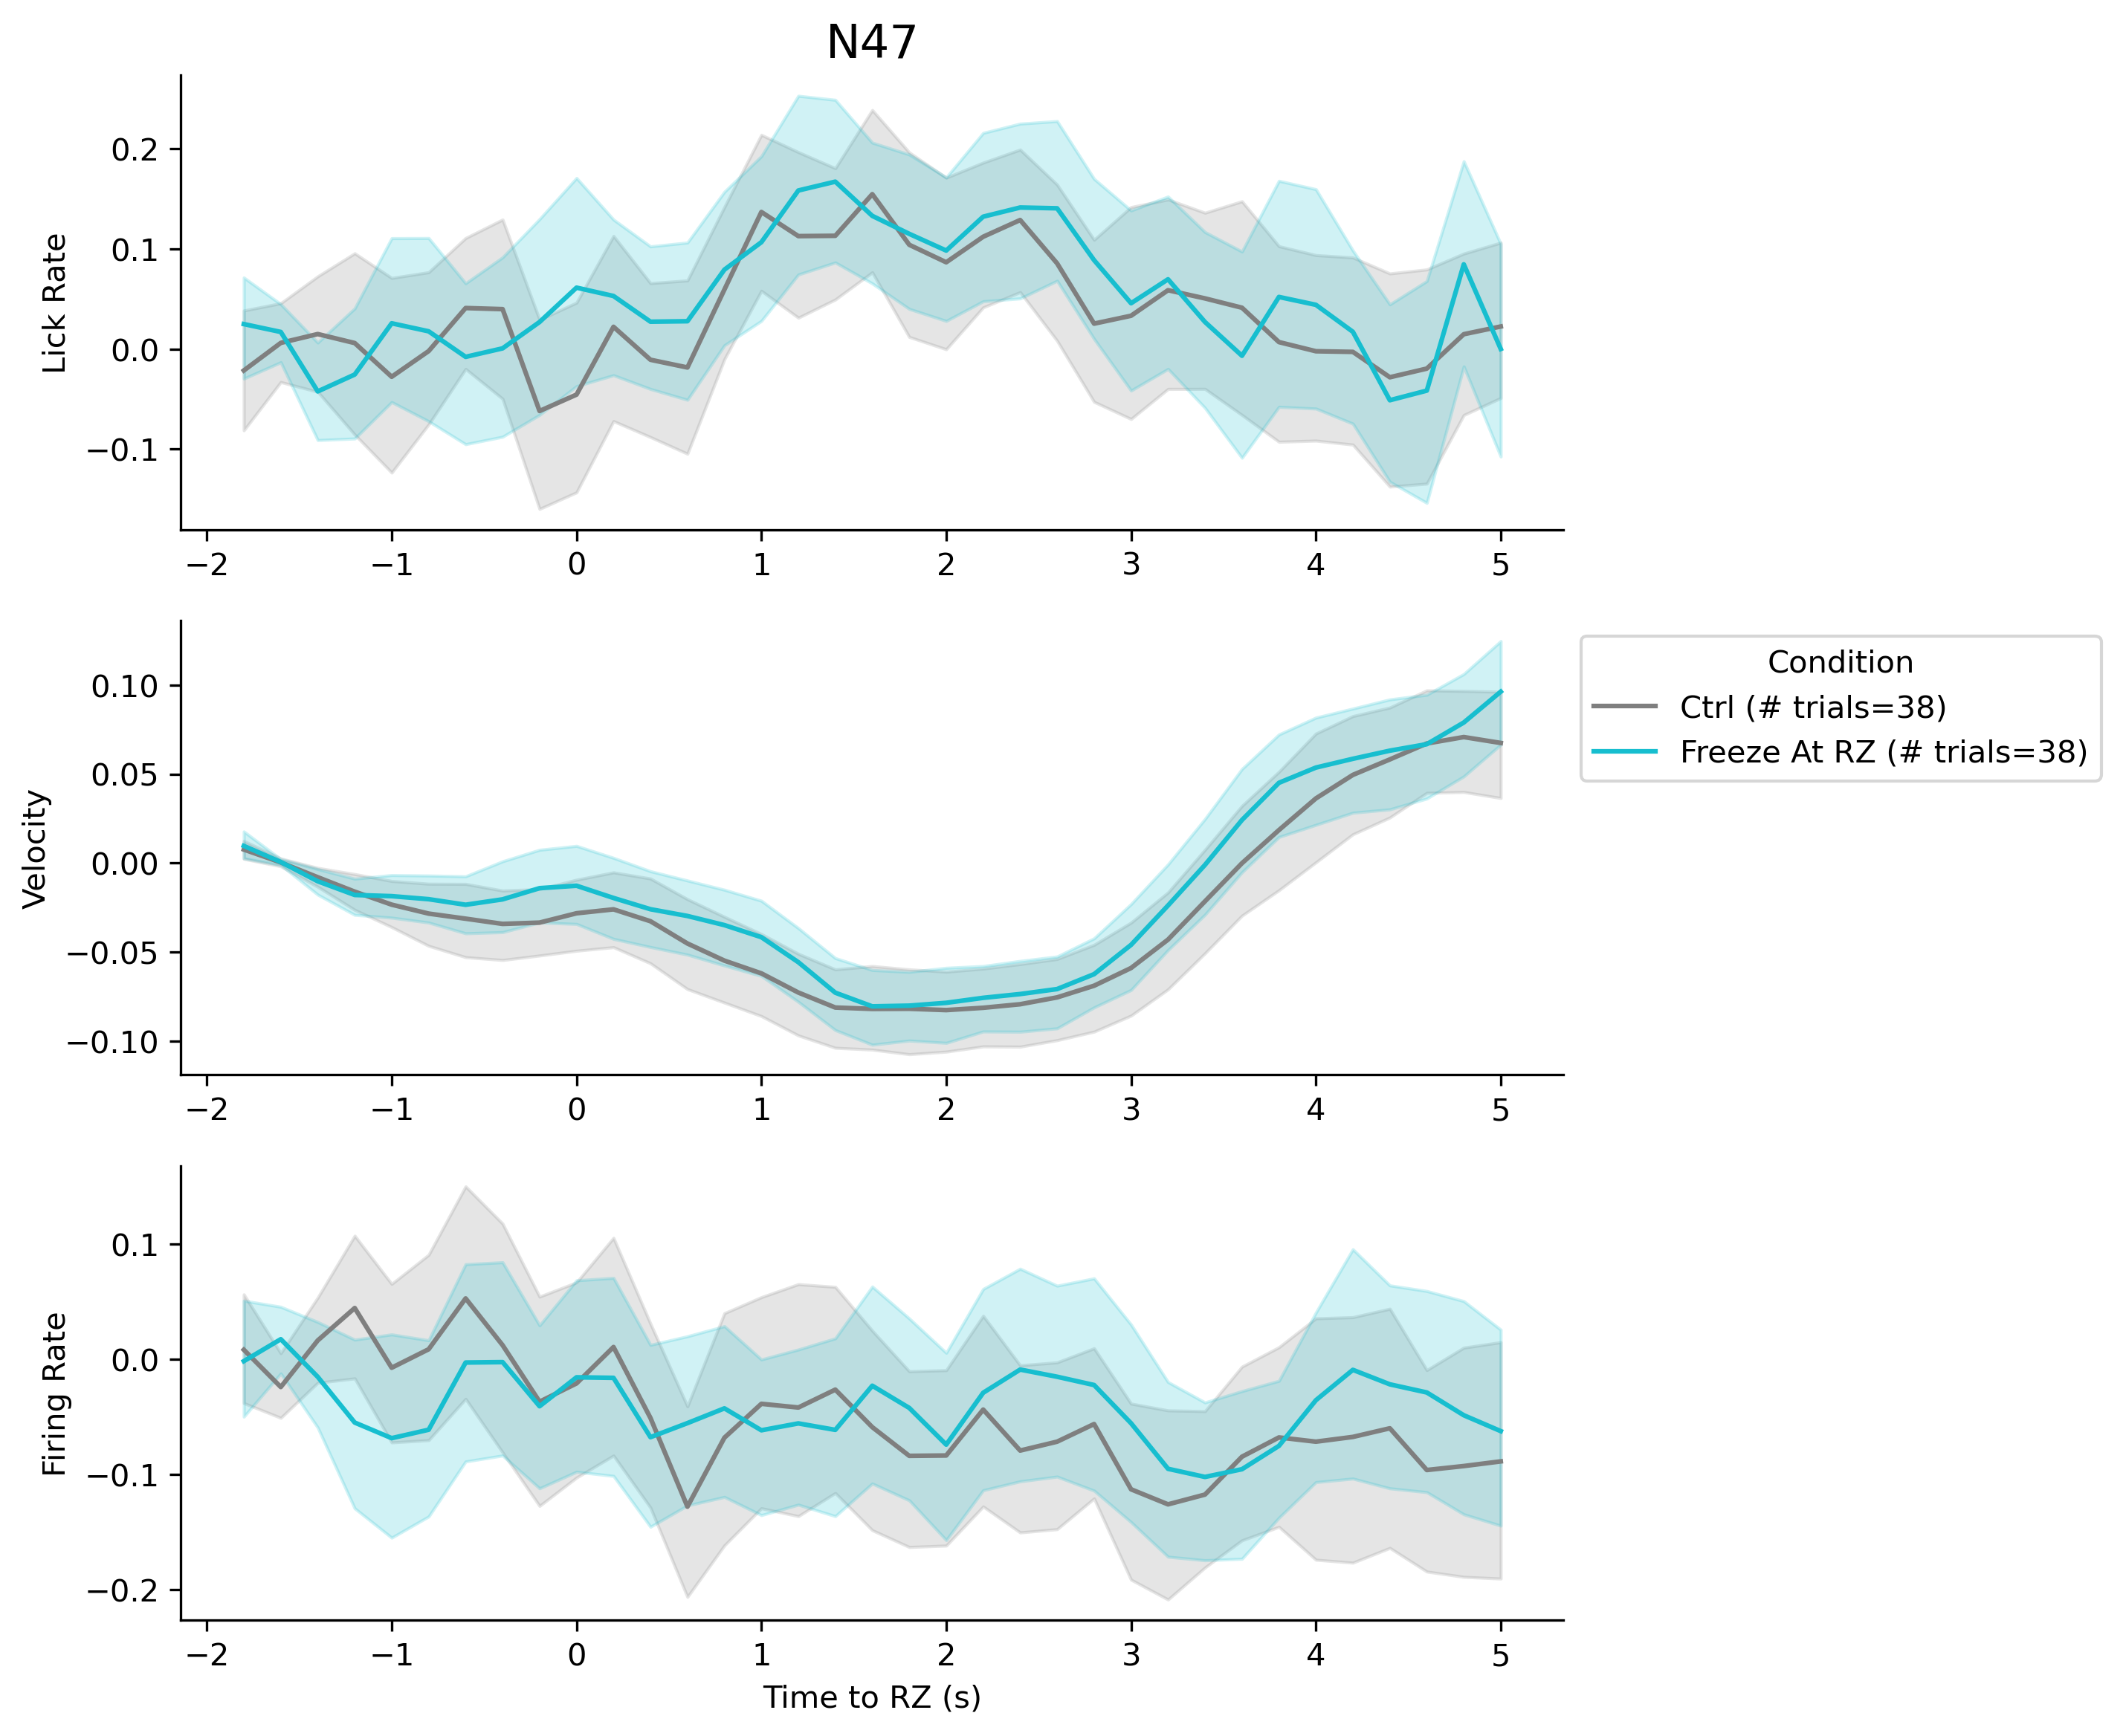

In [7]:
N47_ratemap_df_trialvar, N47_ratemap_df_neuronvar, N47_ratemap_df_diff_neuronvar, N47_lickrate_df, N47_velocity_df, N47_ctrl_trial_num, N47_freeze_trial_num, N47_neuron_num = load_data(ratemapDir, "N47", normalizeNeuron=True, normalizeVel=True, scaleNeuron=True, scaleVel=True, scaleLickrate=True, resample = True, min_timebin = -1.8, max_timebin = 5.2)
plot_time_course("N47", N47_ratemap_df_trialvar, N47_lickrate_df, N47_velocity_df, N47_ctrl_trial_num, N47_freeze_trial_num, saveDir=figDir)

# X8

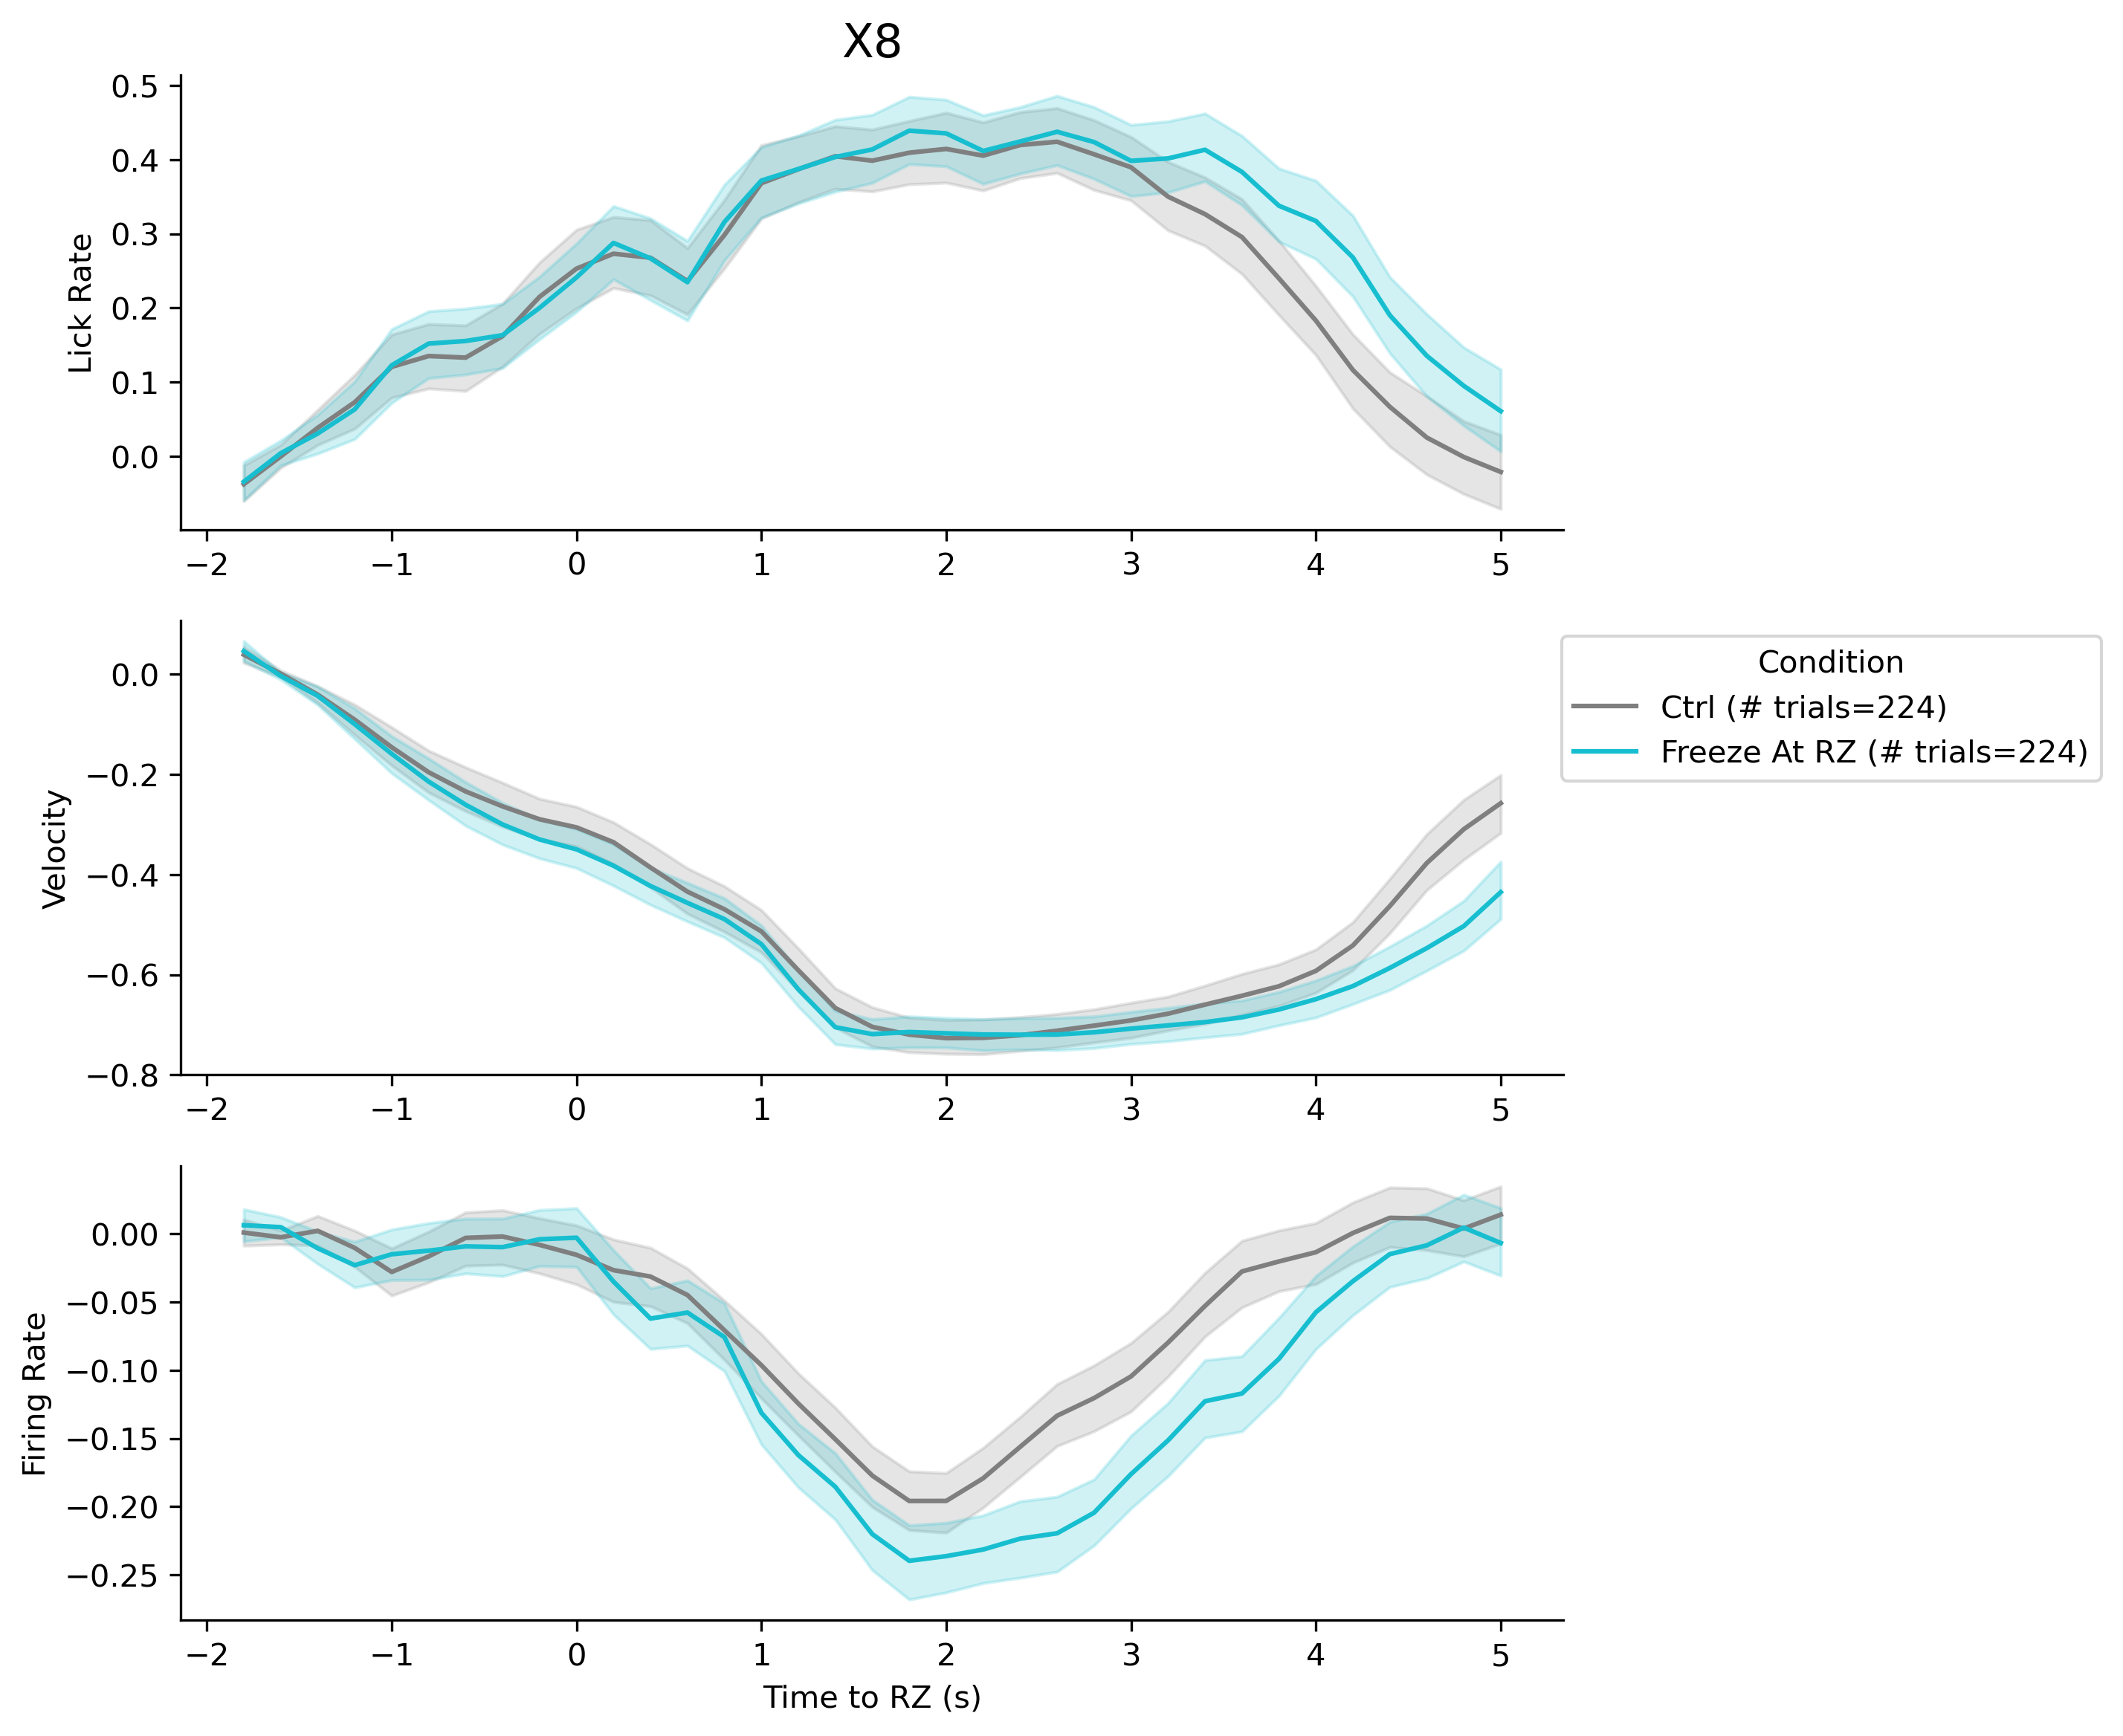

In [8]:
X8_ratemap_df_trialvar, X8_ratemap_df_neuronvar, X8_ratemap_df_diff_neuronvar, X8_lickrate_df, X8_velocity_df, X8_ctrl_trial_num, X8_freeze_trial_num, X8_neuron_num = load_data(ratemapDir, "X8", normalizeNeuron=True, normalizeVel=True, scaleNeuron=True, scaleVel=True, scaleLickrate=True, resample = True, min_timebin = -1.8, max_timebin = 5.2)
plot_time_course("X8", X8_ratemap_df_trialvar, X8_lickrate_df, X8_velocity_df, X8_ctrl_trial_num, X8_freeze_trial_num, saveDir=figDir)

# X10

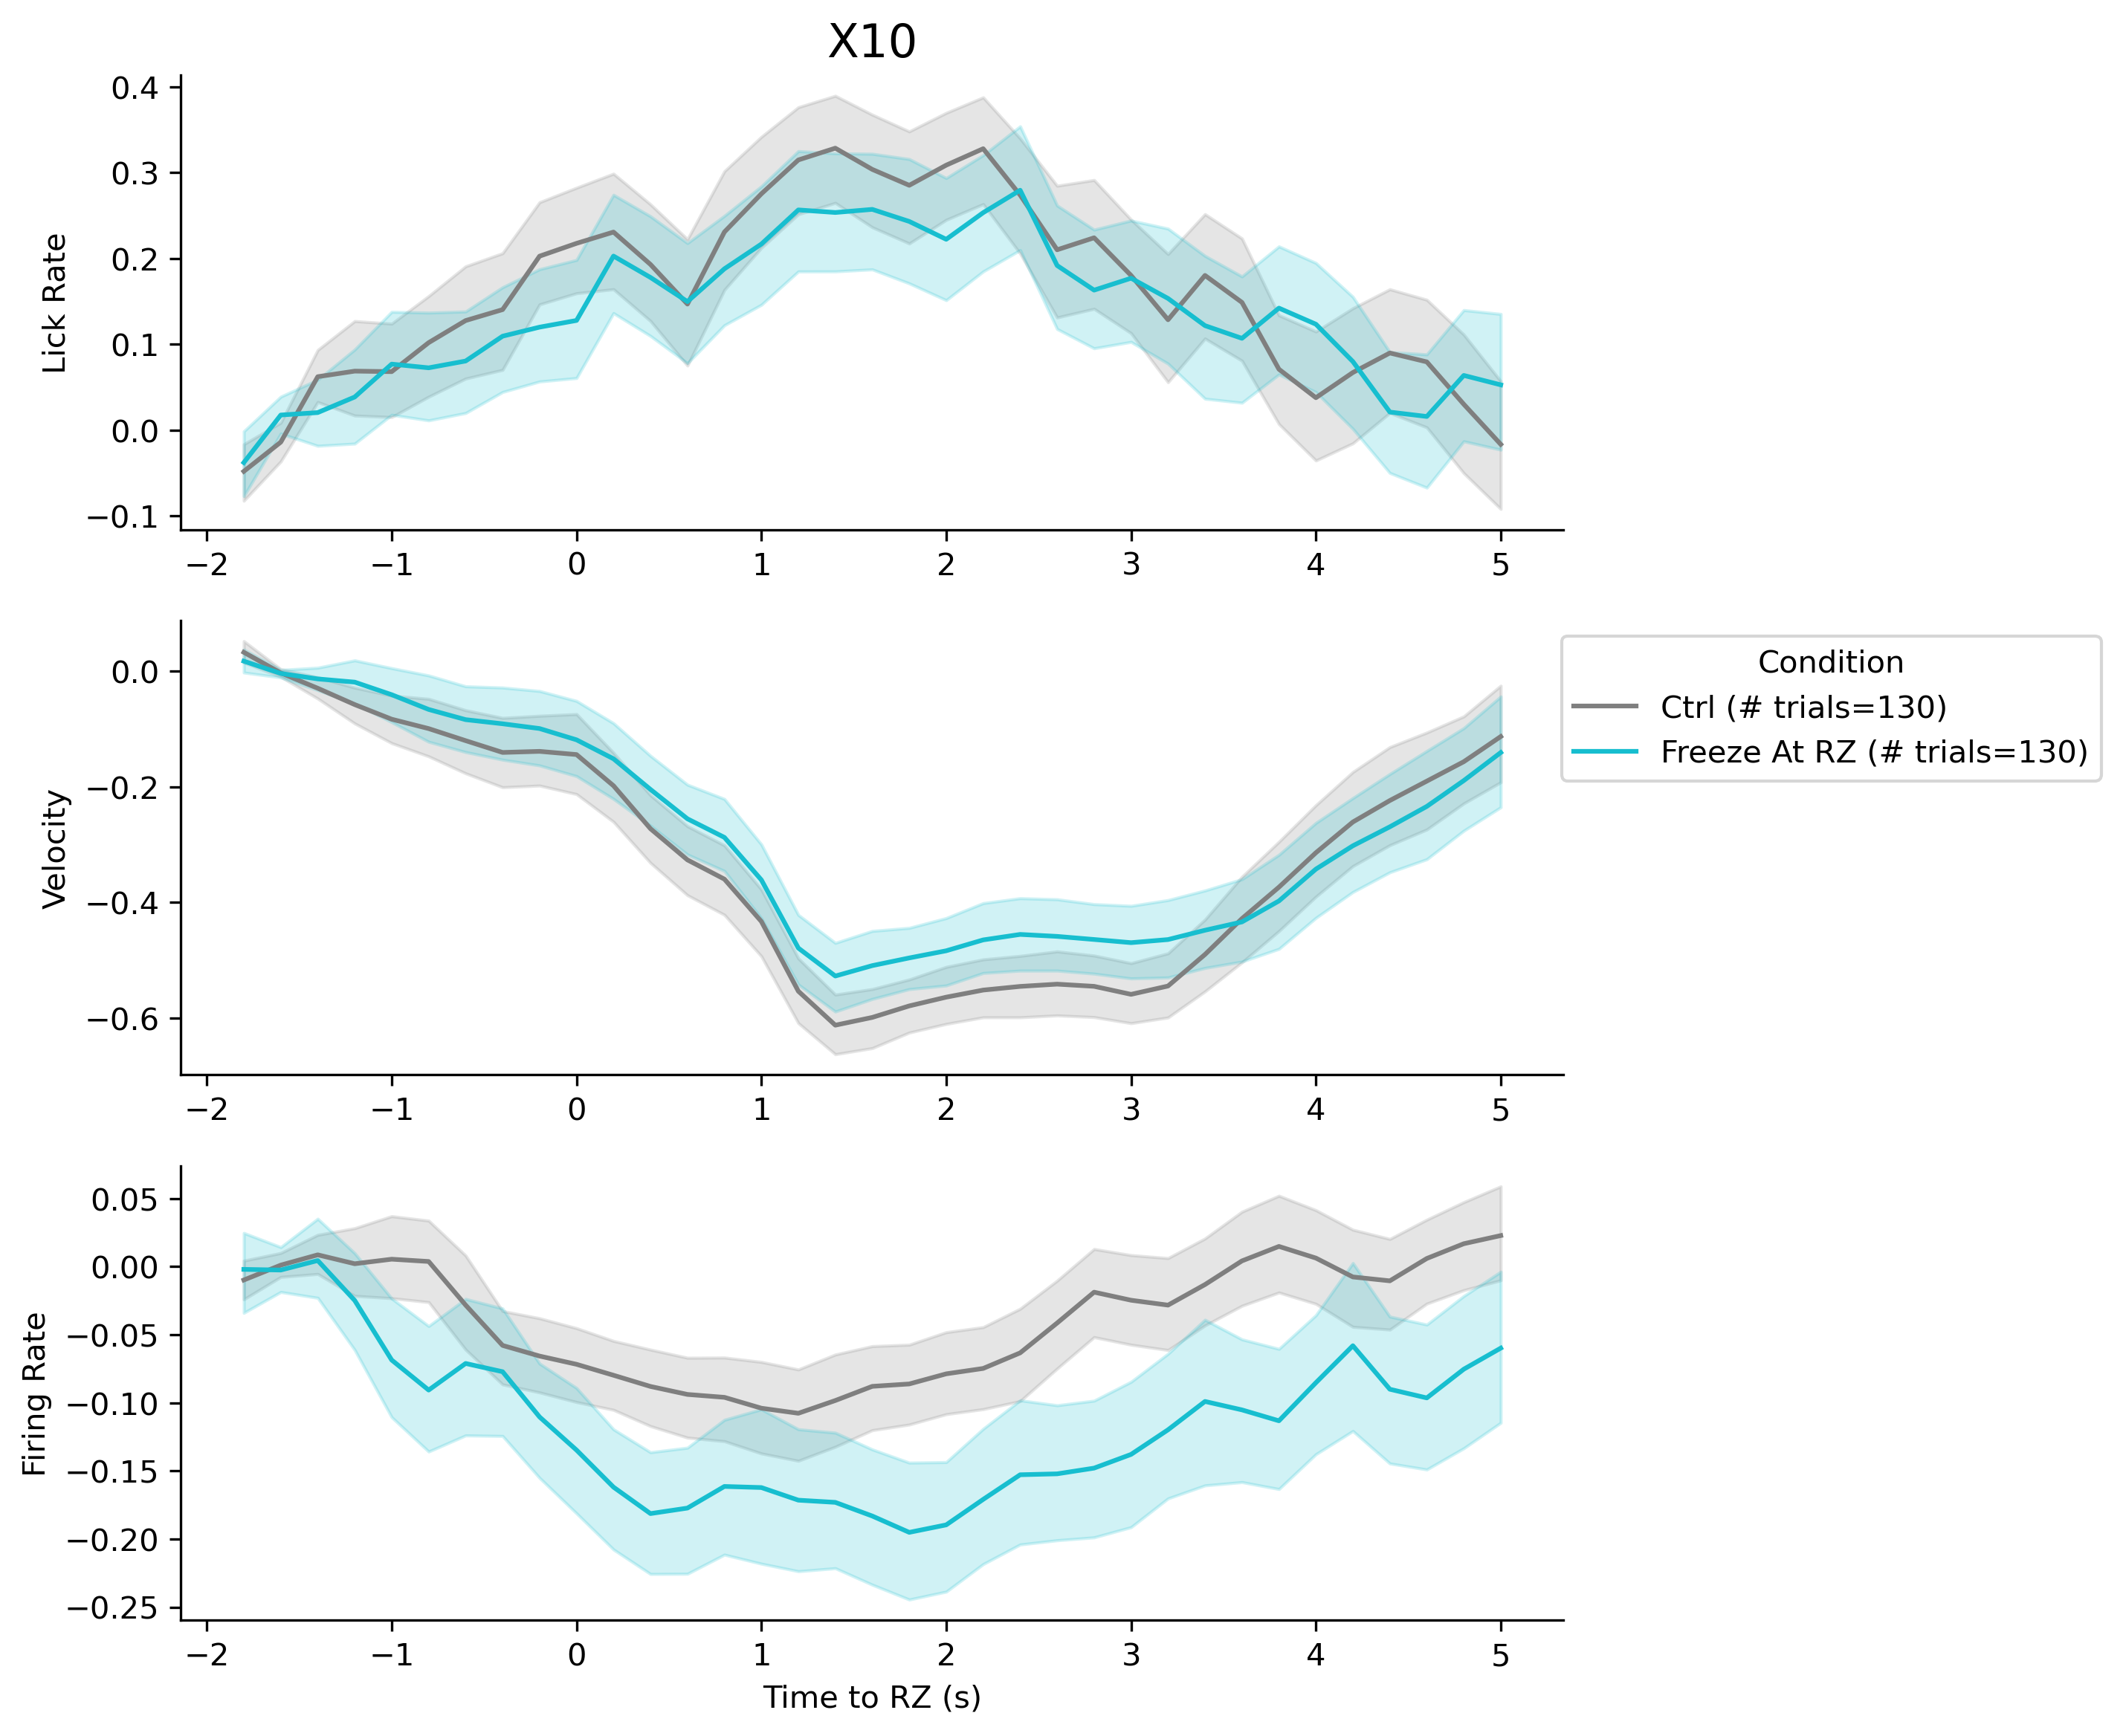

In [9]:
X10_ratemap_df_trialvar, X10_ratemap_df_neuronvar, X10_ratemap_df_diff_neuronvar, X10_lickrate_df, X10_velocity_df, X10_ctrl_trial_num, X10_freeze_trial_num, X10_neuron_num = load_data(ratemapDir, "X10", normalizeNeuron=True, normalizeVel=True, scaleNeuron=True, scaleVel=True, scaleLickrate=True, resample = True, min_timebin = -1.8, max_timebin = 5.2)
plot_time_course("X10", X10_ratemap_df_trialvar, X10_lickrate_df, X10_velocity_df, X10_ctrl_trial_num, X10_freeze_trial_num, saveDir=figDir)

# Summary plot 

In [10]:
N46_neuron_num + N47_neuron_num + X8_neuron_num + X10_neuron_num

17

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Ctrl v.s. Freeze at RZ: t-test paired samples with Bonferroni correction, P_val=3.143e-01 stat=-1.009e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Ctrl v.s. Freeze at RZ: t-test paired samples with Bonferroni correction, P_val=2.752e-01 stat=-1.094e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Ctrl v.s. Freeze at RZ: Custom statistical test, P_val:1.789e-03


(-3.410780125464182, 0.001788921048631813)

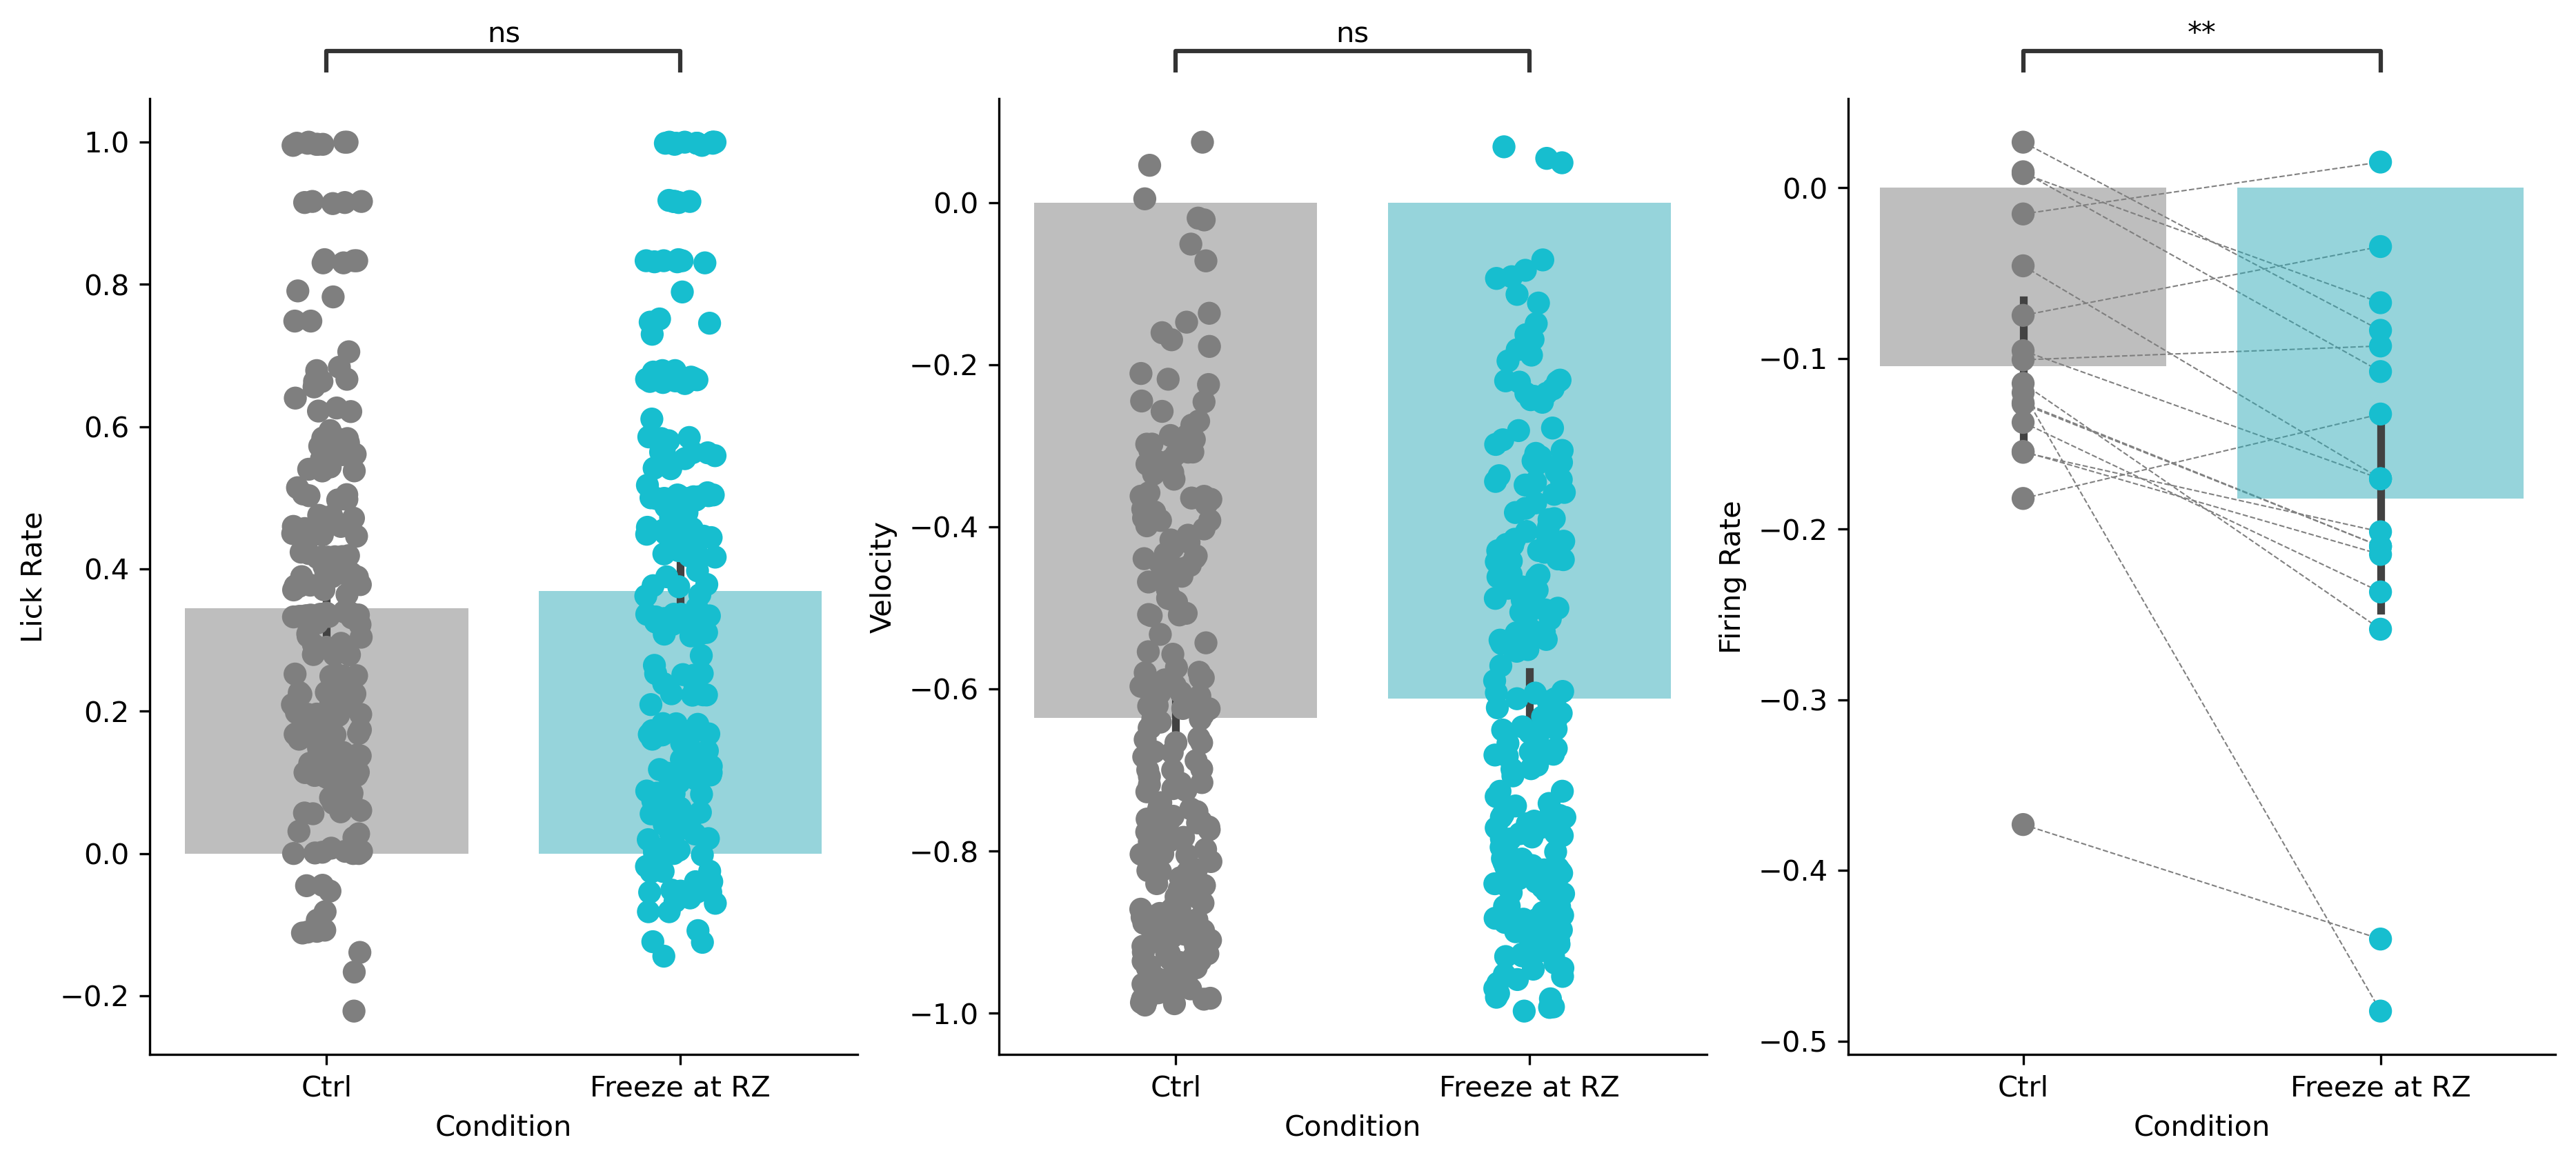

In [11]:
# Extended Data Fig. 3C
# Use 2-3 sec post RZ onset to calculate velocity, lick rate and interneuron firing rates. Resulting p values undergo FDR correction
min_time = 2
max_time = 3
interval = max_time - min_time
N46_ratemap_df_neuronvar_1 = N46_ratemap_df_neuronvar[(N46_ratemap_df_neuronvar["Time to RZ (s)"] >=min_time) & (N46_ratemap_df_neuronvar["Time to RZ (s)"] <=max_time)]
N47_ratemap_df_neuronvar_1 = N47_ratemap_df_neuronvar[(N47_ratemap_df_neuronvar["Time to RZ (s)"] >=min_time) & (N47_ratemap_df_neuronvar["Time to RZ (s)"] <=max_time)]
N46_lickrate_df_1 = N46_lickrate_df[(N46_lickrate_df["Time to RZ (s)"] >=min_time) & (N46_lickrate_df["Time to RZ (s)"] <=max_time)]
N47_lickrate_df_1 = N47_lickrate_df[(N47_lickrate_df["Time to RZ (s)"] >=min_time) & (N47_lickrate_df["Time to RZ (s)"] <=max_time)]
N46_velocity_df_1 = N46_velocity_df[(N46_velocity_df["Time to RZ (s)"] >=min_time) & (N46_velocity_df["Time to RZ (s)"] <=max_time)]
N47_velocity_df_1 = N47_velocity_df[(N47_velocity_df["Time to RZ (s)"] >=min_time) & (N47_velocity_df["Time to RZ (s)"] <=max_time)]

# min_time = 4 # 3.5 min
# max_time = 5
X8_ratemap_df_neuronvar_1 = X8_ratemap_df_neuronvar[(X8_ratemap_df_neuronvar["Time to RZ (s)"] >=min_time) & (X8_ratemap_df_neuronvar["Time to RZ (s)"] <=max_time)]
X10_ratemap_df_neuronvar_1 = X10_ratemap_df_neuronvar[(X10_ratemap_df_neuronvar["Time to RZ (s)"] >=min_time) & (X10_ratemap_df_neuronvar["Time to RZ (s)"] <=max_time)]
X8_lickrate_df_1 = X8_lickrate_df[(X8_lickrate_df["Time to RZ (s)"] >=min_time) & (X8_lickrate_df["Time to RZ (s)"] <=max_time)]
X10_lickrate_df_1 = X10_lickrate_df[(X10_lickrate_df["Time to RZ (s)"] >=min_time) & (X10_lickrate_df["Time to RZ (s)"] <=max_time)]
X8_velocity_df_1 = X8_velocity_df[(X8_velocity_df["Time to RZ (s)"] >=min_time) & (X8_velocity_df["Time to RZ (s)"] <=max_time)]
X10_velocity_df_1 = X10_velocity_df[(X10_velocity_df["Time to RZ (s)"] >=min_time) & (X10_velocity_df["Time to RZ (s)"] <=max_time)]

# reindex neurons so that the 'variable' doesn't overlap across animals
N47_ratemap_df_neuronvar_1["variable"]  = N47_ratemap_df_neuronvar_1["variable"] + max(N46_ratemap_df_neuronvar_1["variable"]) + 1
X8_ratemap_df_neuronvar_1["variable"]  = X8_ratemap_df_neuronvar_1["variable"] + max(N47_ratemap_df_neuronvar_1["variable"]) + 1
X10_ratemap_df_neuronvar_1["variable"]  = X10_ratemap_df_neuronvar_1["variable"] + max(X8_ratemap_df_neuronvar_1["variable"]) + 1

all_ratemap_df_neuronvar_1 = pd.concat([N46_ratemap_df_neuronvar_1, N47_ratemap_df_neuronvar_1, X8_ratemap_df_neuronvar_1, X10_ratemap_df_neuronvar_1])
all_velocity_df_1 = pd.concat([N46_velocity_df_1, N47_velocity_df_1, X8_velocity_df_1, X10_velocity_df_1])
all_lickrate_df_1 = pd.concat([N46_lickrate_df_1, N47_lickrate_df_1, X8_lickrate_df_1, X10_lickrate_df_1])
all_trial_num_1 = N46_ctrl_trial_num + N47_ctrl_trial_num + X8_ctrl_trial_num + X10_ctrl_trial_num
plot_bars("All animals", all_lickrate_df_1, all_velocity_df_1, all_ratemap_df_neuronvar_1, 0, 10, figDir)
# plt.suptitle('paired ttest, interval=' + str(interval) + ', time=' + str(min_time) + '-' + str(max_time) + ', pval=' + str(p_val))
